In [1]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = Path(os.environ["DATA_PATH"])
results_path = Path("./results")

<Axes: >

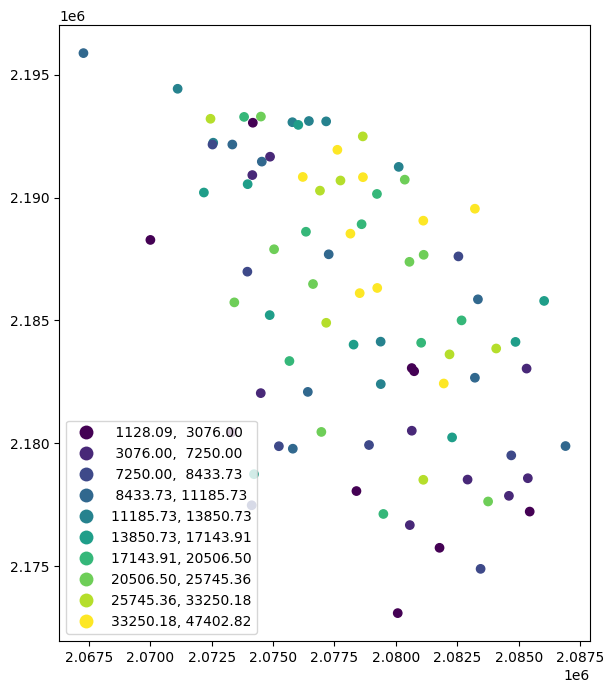

In [3]:
df_estaciones = gpd.read_file(data_path / "datos" / "aforos_vehiculares.gpkg").to_crs(
    "EPSG:6372",
)

years = [
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
    "2024",
]
cols = [f"TDPA_{year}" for year in years]
df_estaciones[years] = df_estaciones[cols].replace(0, np.nan)
df_estaciones["TDPA_mean"] = df_estaciones[cols].mean(axis=1)
df_estaciones.plot(
    column="TDPA_mean",
    scheme="quantiles",
    k=10,
    legend=True,
    figsize=(8, 8),
)

array([[<Axes: title={'center': 'TDPA_mean'}>]], dtype=object)

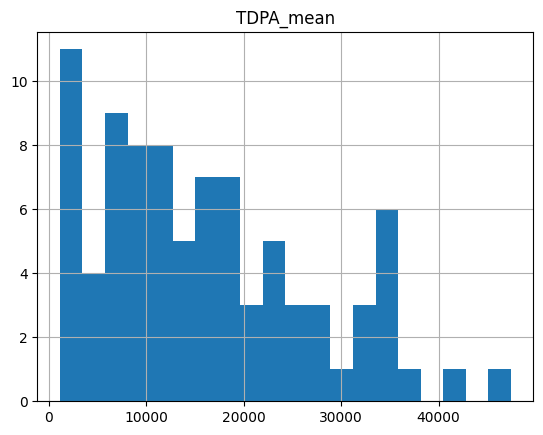

In [4]:
df_estaciones.hist(column="TDPA_mean", bins=20)

In [5]:
gdf_vialidades = gpd.read_file(
    data_path / "datos" / "SAP_Vialildad_Primaria.geojson",
).to_crs(
    "EPSG:6372",
)
gdf_vialidades = gdf_vialidades.dissolve(by=["NOMBRE_DE_"]).reset_index()

# toma el promedio del trafico vehicular de las estaciones cercanas a cada vialidad
street_mean_tdpa = (
    gpd.sjoin_nearest(
        df_estaciones[["Id", "TDPA_mean", "geometry"]],
        gdf_vialidades[["ID", "geometry"]],
        how="left",
        distance_col="dist_to_street",
        max_distance=20,
    )
    .groupby("ID")["TDPA_mean"]
    .median()
    .reset_index()
)
gdf_vialidades = gdf_vialidades.merge(street_mean_tdpa, on="ID", how="left")

<Axes: >

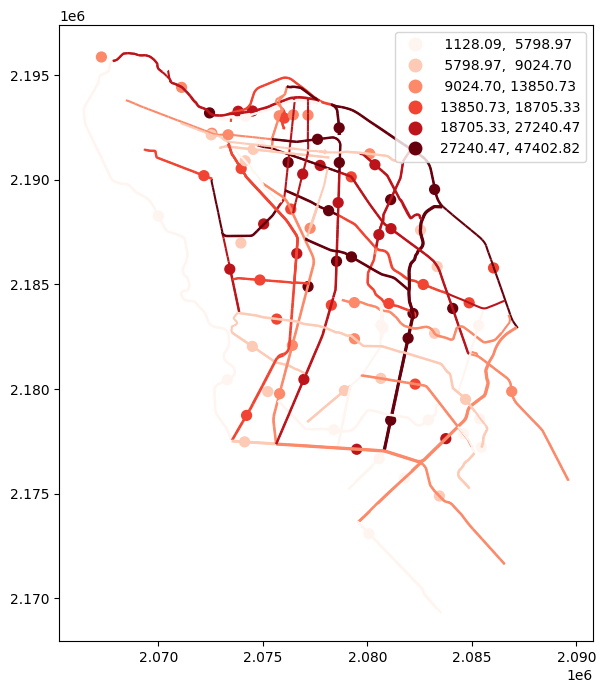

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf_vialidades.plot(column="TDPA_mean", ax=ax, cmap="Reds", scheme="quantiles", k=6)
df_estaciones.plot(
    ax=ax,
    column="TDPA_mean",
    legend=True,
    cmap="Reds",
    markersize=50,
    scheme="quantiles",
    k=6,
)

In [7]:
gdf_vialidades.to_file(results_path / "vialidades.gpkg")